## Look at "Value" from the Value Model

Hoping to see: within a block, "value" of rule increases as trials progress, with jumps in value occuring after to correct feedbacks

### Setup

In [2]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import pickle

from models.value_models import ValueReLUModel, ValueLinearModel
from models.model_wrapper import ModelWrapper

from models.trainer import Trainer

import torch

matplotlib.rcParams['figure.dpi'] = 150


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

In [3]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)

In [4]:
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))

### Train Model with all the trial data
- Grab all trials to train (fit) model
- Training on time bin 700ms before feedback event
- Model: fully connected layer from neurons to 12 values, 12 values go through a ReLU operation (to avoid negative values)
- 70% accuracy for choice decoding


0.6832475700400229


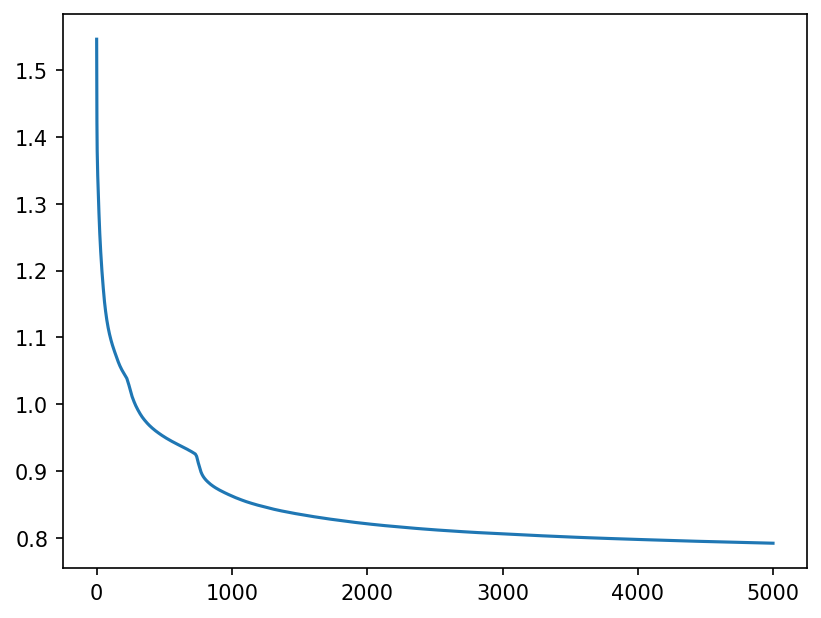

In [22]:
pre_interval = 1300
post_interval = 1500
device = "cuda" if torch.cuda.is_available() else "cpu"


num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_values": 12}
trainer = Trainer(learning_rate=0.1, max_iter=5000)
model = ValueLinearModel(**init_params)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
# just look at one time bin
# look at 0.6 because that should be where decodabilty is highest
inputs = inputs[np.isclose(inputs["TimeBins"], 0.6)]
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

x_train = classifier_utils.transform_to_input_data(inputs)
cards_train = classifier_utils.transform_cards_or_none(shuffled_card_idxs)
y_train = classifier_utils.transform_to_label_data(labels)

possible_labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
labels_to_idx = {label: idx for idx, label in enumerate(possible_labels)}
y_train_idxs = np.array([labels_to_idx[label] for label in y_train.tolist()]).astype(int)

losses = trainer.train(model, x_train, y_train_idxs, cards_train)

x = torch.Tensor(x_train).to(device)
cards = torch.Tensor(cards_train).to(torch.long).to(device)

probs = model(x, cards)
label_idxs = np.argmax(probs.detach().cpu().numpy(), axis=1)
train_acc = np.sum(label_idxs == y_train_idxs) / len(y_train_idxs)

print(train_acc)

fig, ax = plt.subplots()
ax.plot(losses)

### Grab all values from decoder across all trials

In [6]:
# choose block number as 1
# rule as CYAN
# index as 4

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.squeeze().detach().cpu().numpy()
    return hook

model.relu.register_forward_hook(get_activation("linear"))

trial_numbers = valid_beh.TrialNumber.unique()

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
# just look at one time bin
# look at 0.6 because that should be where decodabilty is highest
inputs = inputs[np.isclose(inputs["TimeBins"], 0.6)]
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

x = classifier_utils.transform_to_input_data(inputs)
cards = classifier_utils.transform_cards_or_none(shuffled_card_idxs)

x = torch.Tensor(x).to(device)
cards = torch.Tensor(cards).to(torch.long).to(device)
res = model(x, cards)

feature_values = activation["linear"].T

print(feature_values.shape)


(12, 1749)


### Do some dataframe magic to get Trial idxs

In [7]:
reindexed = valid_beh.reset_index()
valid_beh["TrialIdx"] = reindexed.index

/tmp/ipykernel_370399/3544055230.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_beh["TrialIdx"] = reindexed.index


### Look at some blocks

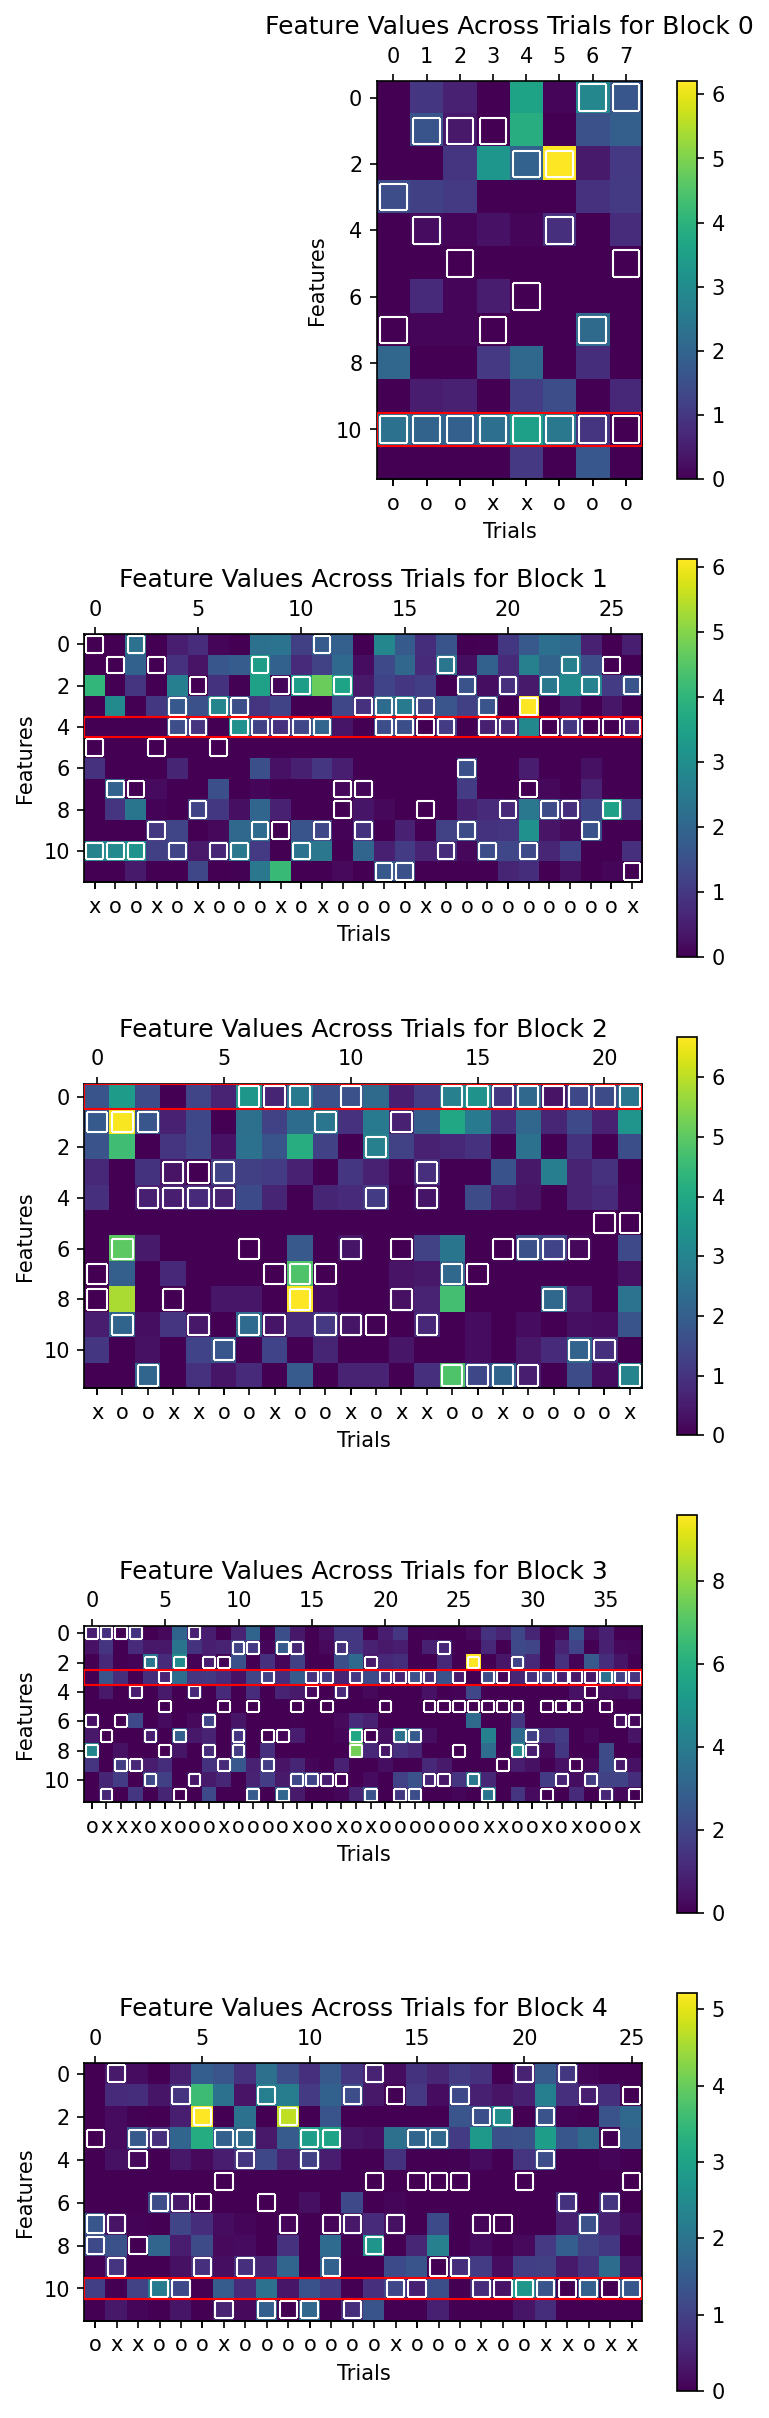

In [29]:
corrects = label_idxs == y_train_idxs
correct_labels = np.array(["o" if correct else "x" for correct in corrects])


def draw_square(x, y, ax):
    left = x - 0.4
    right = x + 0.4
    top = y - 0.4
    bottom = y + 0.4
    hor = ax.hlines(y=[top, bottom], xmin=left, xmax=right, color='white', linewidths=1)
    vert = ax.vlines(x=[left, right], ymin=top, ymax=bottom, color='white', linewidths=1)

def draw_selected_features_for_block(trial_numbers, shuffled_card_idxs, ax):
    for trial_idx, trial_number in enumerate(np.sort(trial_numbers)):
        row = shuffled_card_idxs[shuffled_card_idxs.TrialNumber == trial_number]
        chosen = int(row.ItemChosen)
        for dim in ["Color", "Shape", "Pattern"]:
            feature_idx = classifier_utils.FEATURES.index(row[f"Item{chosen}{dim}"].iloc[0])
            draw_square(trial_idx, feature_idx, ax)

def draw_rule_for_block(rule_idx, x_max, ax):
    left = 0 - 0.5
    right = x_max + 0.5
    top = rule_idx - 0.5
    bottom = rule_idx + 0.5
    hor = ax.hlines(y=[top, bottom], color='red', xmin=left, xmax=right, linewidths=1, zorder=4)
    vert = ax.vlines(x=[left, right], ymin=top, ymax=bottom, color='red', linewidths=1, zorder=4)


blocks = [0, 1, 2, 3, 4]

fig, axs = plt.subplots(len(blocks), 1, figsize=(6, len(blocks) * 4))


for i, block_number in enumerate(blocks):
    ax = axs[i]
    trial_idxs = valid_beh[valid_beh.BlockNumber == block_number].TrialIdx
    trial_numbers = valid_beh[valid_beh.BlockNumber == block_number].TrialNumber
    rule_idx = classifier_utils.FEATURES.index(valid_beh[valid_beh.BlockNumber == block_number].CurrentRule.unique()[0])
    correct_labels_block = correct_labels[trial_idxs]
    block_values = feature_values[:, trial_idxs]

    colors = ax.matshow(block_values)

    draw_rule_for_block(rule_idx, len(trial_numbers) - 1, ax)
    draw_selected_features_for_block(trial_numbers, shuffled_card_idxs, ax)

    bottom_x_axis = ax.secondary_xaxis('bottom')
    bottom_x_axis.set_xlabel("Trials")
    bottom_x_axis.set_xticks(np.arange(len(correct_labels_block)))
    bottom_x_axis.set_xticklabels(correct_labels_block)


    # draw_selected_features_for_block([8], shuffled_card_idxs, ax)

    fig.colorbar(colors, ax=ax)

    ax.set_ylabel("Features")
    ax.set_title(f"Feature Values Across Trials for Block {block_number}")


### Plot Value of CYAN across trials in that block
- Looking at relative value of CYAN, val of cyan / total value for that trial
- Plotting Correct/Incorrect

[0.1023985  0.         0.         0.07620478 0.11103917 0.07503681
 0.00649121 0.12025722 0.05821204 0.04522763 0.133565   0.13495523
 0.04041326 0.01816116 0.07468569 0.06774811 0.05263197 0.10507355
 0.015793   0.09691698 0.06406845 0.111229   0.04155403 0.05894646
 0.03915172 0.04872965 0.0915817 ]


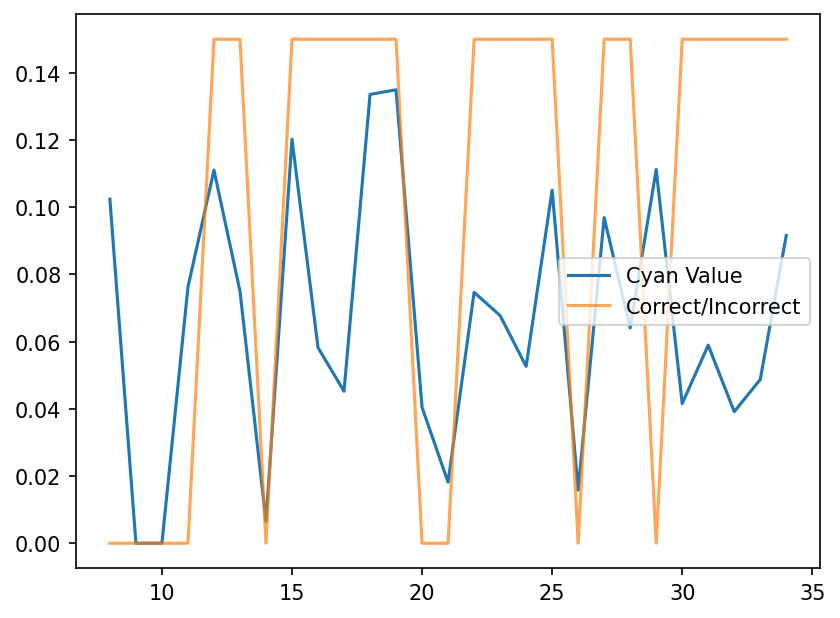

In [10]:
CYAN_IDX = 4
trial_nums = values.keys()
cyan_values = np.array([v[CYAN_IDX] for v in values.values()])
total_values = np.array([np.sum(v) for v in values.values()])
relative_cyan_values = cyan_values / total_values
print(relative_cyan_values)

correct = valid_beh[valid_beh.BlockNumber == 1].Response == "Correct"
correct = correct.astype(int)
correct = correct * 0.15


fig, ax = plt.subplots()
ax.plot(trial_nums, relative_cyan_values, label="Cyan Value")
ax.plot(correct.index, correct.values, label="Correct/Incorrect", alpha=0.7)
ax.legend()

In [5]:
len(valid_beh.BlockNumber.unique())


56

In [25]:
shuffled_card_idxs

,Item3Color,Item2Color,Item1Color,Item0Color,Item3Shape,Item2Shape,Item1Shape,Item0Shape,Item3Pattern,Item2Pattern,Item1Pattern,Item0Pattern,ItemChosen,TrialNumber
0,YELLOW,GREEN,CYAN,MAGENTA,TRIANGLE,STAR,CIRCLE,SQUARE,RIPPLE,POLKADOT,ESCHER,SWIRL,3,0
1,CYAN,MAGENTA,GREEN,YELLOW,SQUARE,STAR,CIRCLE,TRIANGLE,RIPPLE,POLKADOT,SWIRL,ESCHER,3,1
2,MAGENTA,CYAN,YELLOW,GREEN,TRIANGLE,STAR,CIRCLE,SQUARE,POLKADOT,ESCHER,SWIRL,RIPPLE,0,2
3,MAGENTA,YELLOW,CYAN,GREEN,STAR,SQUARE,TRIANGLE,CIRCLE,POLKADOT,RIPPLE,SWIRL,ESCHER,2,3
4,YELLOW,MAGENTA,CYAN,GREEN,CIRCLE,STAR,TRIANGLE,SQUARE,POLKADOT,RIPPLE,SWIRL,ESCHER,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744,CYAN,MAGENTA,GREEN,YELLOW,CIRCLE,TRIANGLE,STAR,SQUARE,SWIRL,RIPPLE,ESCHER,POLKADOT,0,1745
1745,MAGENTA,GREEN,CYAN,YELLOW,SQUARE,STAR,CIRCLE,TRIANGLE,POLKADOT,SWIRL,ESCHER,RIPPLE,3,1746
1746,YELLOW,CYAN,MAGENTA,GREEN,CIRCLE,SQUARE,STAR,TRIANGLE,SWIRL,RIPPLE,ESCHER,POLKADOT,3,1747
1747,MAGENTA,GREEN,YELLOW,CYAN,STAR,SQUARE,TRIANGLE,CIRCLE,POLKADOT,ESCHER,RIPPLE,SWIRL,0,1748
